##### Make four files in the same standards of honda_2d_homestake_2015_numu.root from the Bartol flux tables

In [119]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import dunestyle.matplotlib as dunestyle


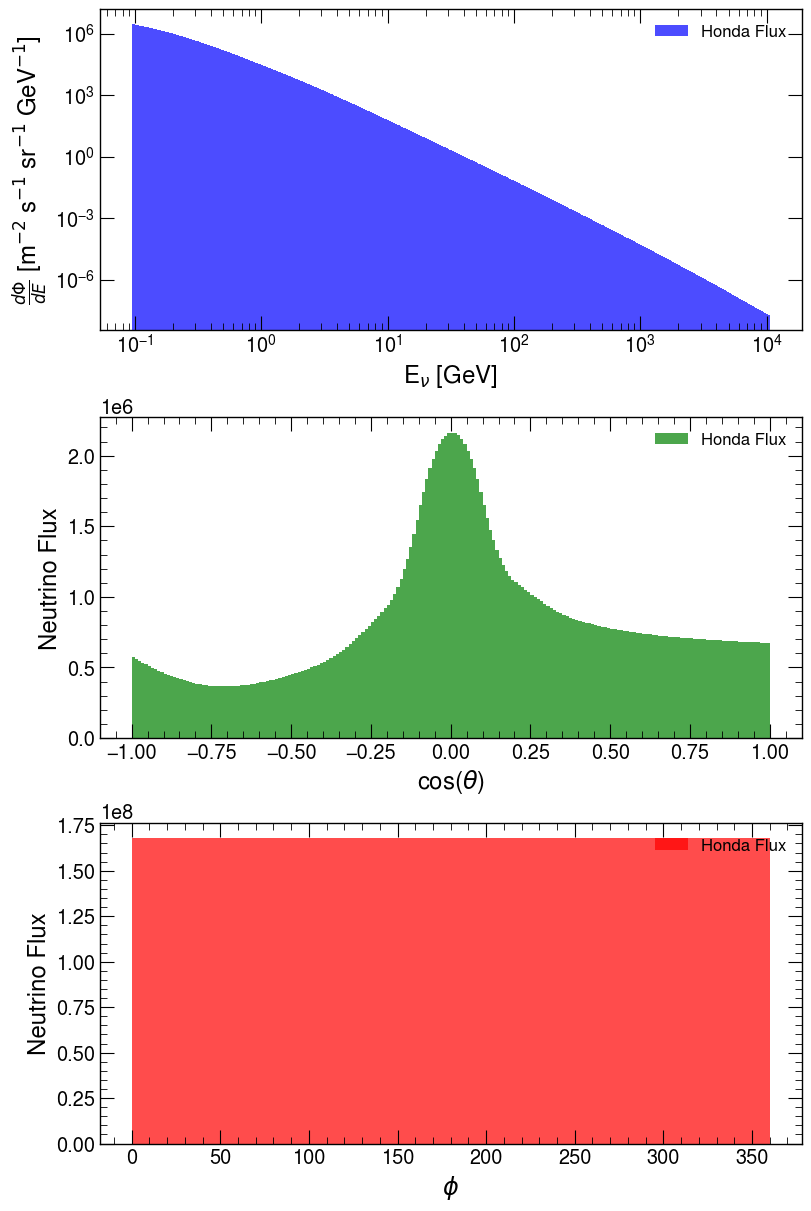

In [128]:

# Open the ROOT file
file_path = "honda_2d_homestake_2015_numu.root"  # Replace with your ROOT file path
histogram_name = "flux"  # Replace with your histogram's name
file = uproot.open(file_path)
hist3d = file[histogram_name]

# Extract the data
x_edges = hist3d.axis(0).edges()  # Bin edges for X
y_edges = hist3d.axis(1).edges()  # Bin edges for Y
z_edges = hist3d.axis(2).edges()  # Bin edges for Z
contents = hist3d.values()  # 3D array of bin contents

# Project onto the X axis (sum over Y and Z)
proj_x = contents.sum(axis=(1, 2))  # Collapse Y and Z axes

# Project onto the Y axis (sum over X and Z)
proj_y = contents.sum(axis=(0, 2))  # Collapse X and Z axes

# Project onto the Z axis (sum over X and Y)
proj_z = contents.sum(axis=(0, 1))  # Collapse X and Y axes

# Plot the projections
fig, axs = plt.subplots(3, 1, figsize=(8, 12), constrained_layout=True)

# Projection onto X axis
axs[0].bar(
    (x_edges[:-1] + x_edges[1:]) / 2, proj_x, width=np.diff(x_edges),
    color='blue', alpha=0.7, label="Honda Flux"
)

#axs[0].set_title("Projection onto X axis")
axs[0].set_xlabel(r"E$_\nu$ [GeV]")
axs[0].set_xscale('log')  # For logarithmic x-axis
axs[0].set_yscale('log')  # For logarithmic y-axis
axs[0].set_ylabel(r"$\frac{d\Phi}{dE}$ [m$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV$^{-1}$]")
axs[0].legend()

# Projection onto Y axis
axs[1].bar(
    (y_edges[:-1] + y_edges[1:]) / 2, proj_y, width=np.diff(y_edges),
    color='green', alpha=0.7, label="Honda Flux"
)
#axs[1].set_title("Projection onto Y axis")
axs[1].set_xlabel(r"cos($\theta$)")
axs[1].set_ylabel("Neutrino Flux")
# only one line may be specified; full height

axs[1].legend()

# Projection onto Z axis
axs[2].bar(
    (z_edges[:-1] + z_edges[1:]) / 2, proj_z, width=np.diff(z_edges),
    color='red', alpha=0.7, label="Honda Flux"
)
#axs[2].set_title("Projection onto Z axis")
axs[2].set_xlabel(r"$\phi$")
axs[2].set_ylabel("Neutrino Flux")
axs[2].legend()


# Show the plots
plt.show()


##### Let's start to work with the Bartol Flux
##### 3D Atmospheric Neutrino Fluxes, using AGLS1996 fluxes

In [121]:

import pandas as pd

# File path to the data file
file_path = 'fmin10_0401z.sou_num'  # Update this with the actual path to your file

# Column names as per the format description
columns = [
    "Energy_Center_GeV",        # Energy at the center of the bin (GeV)
    "Cos_Zenith_or_Azimuth",    # Cos(zenith) or azimuth (degrees)
    "Flux_dN/dlogE_m2_s_sr",    # Flux (dN/d(logE)) in /m²/steradian/sec
    "MC_Stat_Error",            # Monte Carlo statistical error
    "Unweighted_Events"         # Number of unweighted events in the bin
]

# Load the file into a DataFrame
with open(file_path, 'r') as file:
    lines = file.readlines()
    # Find the index where data starts (skip lines beginning with #)
    data_start_idx = next(i for i, line in enumerate(lines) if not line.startswith('#'))

# Read the data into a DataFrame
df_flux = pd.read_csv(
    file_path,
    delim_whitespace=True,  # Columns are separated by whitespace
    skiprows=data_start_idx,  # Skip comment lines
    names=columns           # Assign column names
)
# Drop the first line (row) of the DataFrame
df_flux = df_flux.iloc[1:].reset_index(drop=True)

# Display the first few rows to ensure data is loaded correctly
print(df_flux.head())

  Energy_Center_GeV Cos_Zenith_or_Azimuth  Flux_dN/dlogE_m2_s_sr  \
0             0.112                -0.950             1137.06580   
1             0.141                -0.950              996.10371   
2             0.178                -0.950              868.89056   
3             0.224                -0.950              740.12912   
4             0.282                -0.950              611.99145   

   MC_Stat_Error  Unweighted_Events  
0       9.076886           109163.0  
1       7.993303           111597.0  
2       7.002045           111764.0  
3       6.036622           110096.0  
4       5.125668           104437.0  


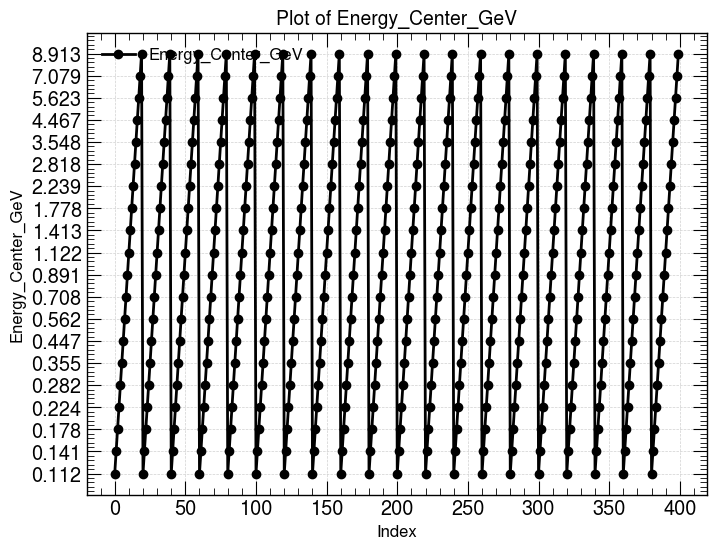

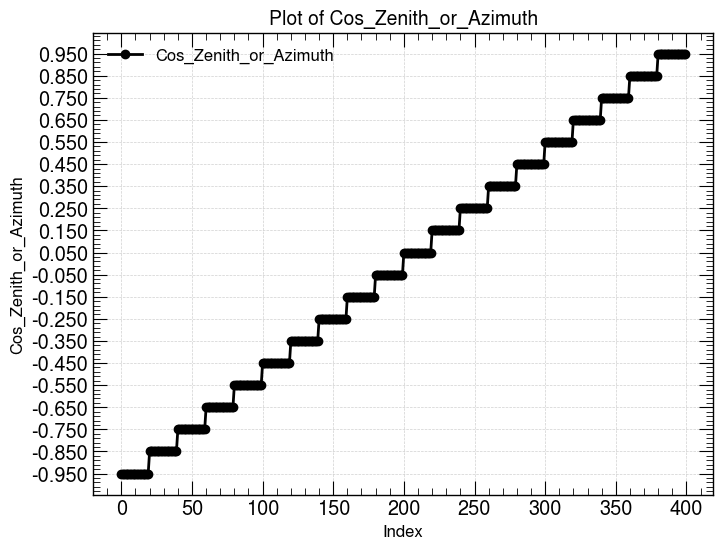

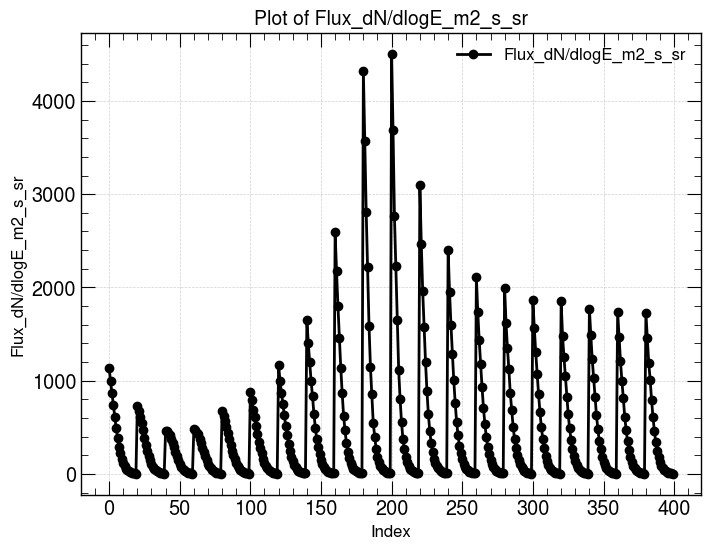

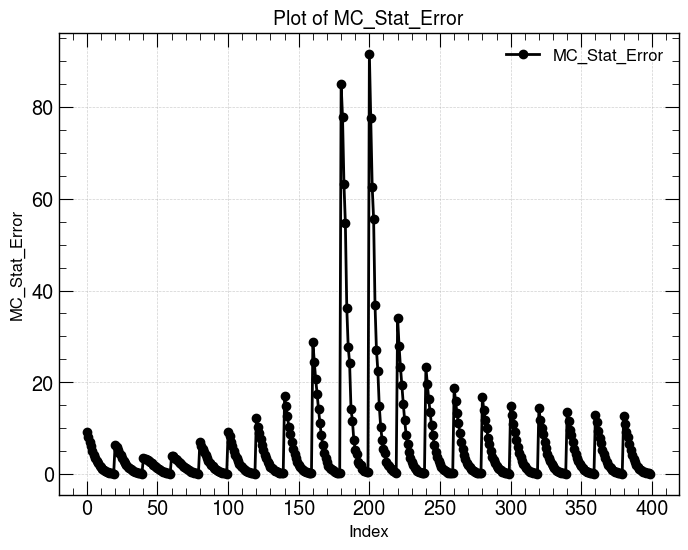

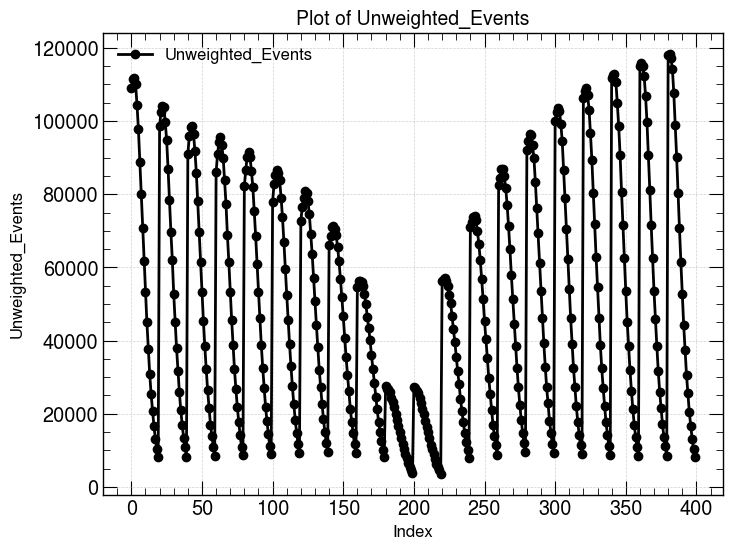

In [122]:
def plot_distribution(dataframe, column, title=None):
    """
    Plots the distribution of a specified column in the DataFrame.
    
    Parameters:
    - dataframe: The DataFrame containing the data.
    - column: The column to plot.
    - title: Optional title for the plot.
    """
    if column not in dataframe.columns:
        print(f"Column '{column}' not found in the DataFrame.")
        return
    
    plt.figure(figsize=(8, 6))
    plt.plot(dataframe[column], marker='o', linestyle='-', label=column)
    plt.xlabel("Index", fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.title(title if title else f"Distribution of {column}", fontsize=14)
    plt.grid(True, alpha=0.6)
    plt.legend()
    plt.show()

# Example usage:
columns_to_plot = [
    "Energy_Center_GeV",
    "Cos_Zenith_or_Azimuth",
    "Flux_dN/dlogE_m2_s_sr",
    "MC_Stat_Error",
    "Unweighted_Events"
]


# Call the function for each column
for col in columns_to_plot:
    plot_distribution(df_flux, col, title=f"Plot of {col}")

In [123]:
import numpy as np
import pandas as pd

# Assuming df_flux is the DataFrame containing the data
cos_values = df_flux["Cos_Zenith_or_Azimuth"].unique()  # Unique cos(zenith) values
results = []

for cos_val in cos_values:
    # Filter the DataFrame for the current cos(zenith) value
    group = df_flux[df_flux["Cos_Zenith_or_Azimuth"] == cos_val]
    
    # Extract energy and flux for this group
    energy = group["Energy_Center_GeV"].values
    flux = group["Flux_dN/dlogE_m2_s_sr"].values

    # Compute the log(E) values
    log_energy = np.log(np.array(energy, dtype=float))

    # Calculate bin widths in log(E)
    log_energy_diff = np.diff(log_energy)

    # Integrate flux over energy for this cos(zenith) value
    integral = np.sum(flux[:-1] * log_energy_diff)
    #print(flux[:-1] * log_energy_diff)

    # Store the result
    results.append({"Cos_Zenith_or_Azimuth": cos_val, "Integrated_Flux": integral})

# Convert results to a DataFrame for easier analysis
df_results = pd.DataFrame(results)

#print(df_results)


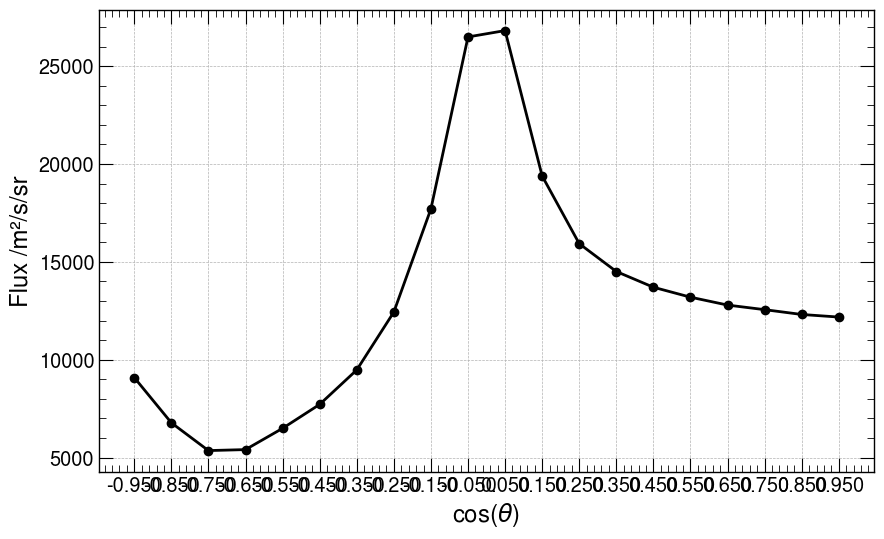

In [124]:
import math as m
plt.figure(figsize=(10, 6))
plt.plot(df_results.iloc[:,0],2*m.pi*df_results.iloc[:,1], marker='o', linestyle='-')
plt.xlabel(r'cos($\theta$)')
plt.ylabel('Flux /m²/s/sr')
plt.grid()
plt.show()


In [132]:
import matplotlib.pyplot as plt

# Assuming df_flux is the DataFrame containing the data
E_values = df_flux["Energy_Center_GeV"].unique()  # Unique cos(zenith) values
results = []

for E_val in E_values:
    # Filter the DataFrame for the current cos(zenith) value
    group = df_flux[df_flux["Energy_Center_GeV"] == E_val]
    
    # Calculate dN/dE
    cos = group["Cos_Zenith_or_Azimuth"].values  # Energy in GeV
    flux_dlogE = group["Flux_dN/dlogE_m2_s_sr"].values  # Flux dN/d(logE)

    # Calculate bin widths in log(E)
    cos_diff = np.diff(np.array(cos,dtype=float))

    # Integrate flux over energy for this cos(zenith) value
    flux_dE = np.sum(flux_dlogE[:-1] * cos_diff)
    flux_dE = flux_dE/float(E_val)  # Convert to dN/dE
    # Store the result
    results.append({"Energy_Center_GeV": E_val, "flux_dE": flux_dE})
    
# Convert results to a DataFrame for easier analysis
df_results = pd.DataFrame(results)

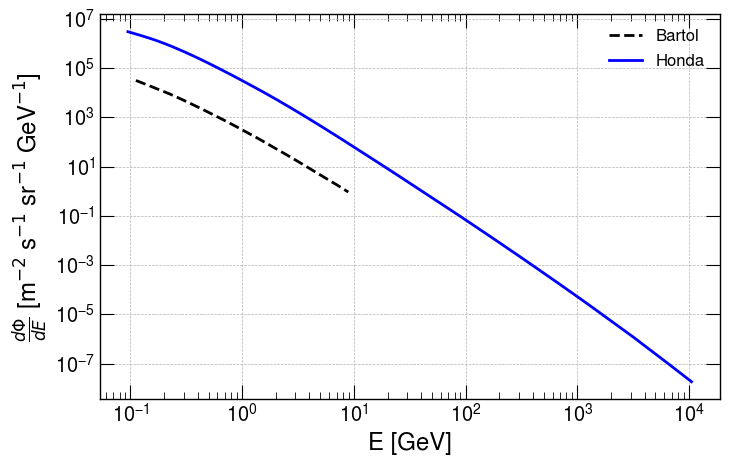

In [133]:
import math as m
df_results = np.array(df_results,dtype=float)
plt.figure(figsize=(8, 5))
plt.plot(df_results[:,0],df_results[:,1], ls = '--',label = 'Bartol')
plt.plot((x_edges[:-1] + x_edges[1:]) / 2, proj_x, color='blue', label="Honda")


plt.xlabel(r'E [GeV]')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel(r"$\frac{d\Phi}{dE}$ [m$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV$^{-1}$]")
plt.grid()
plt.show()


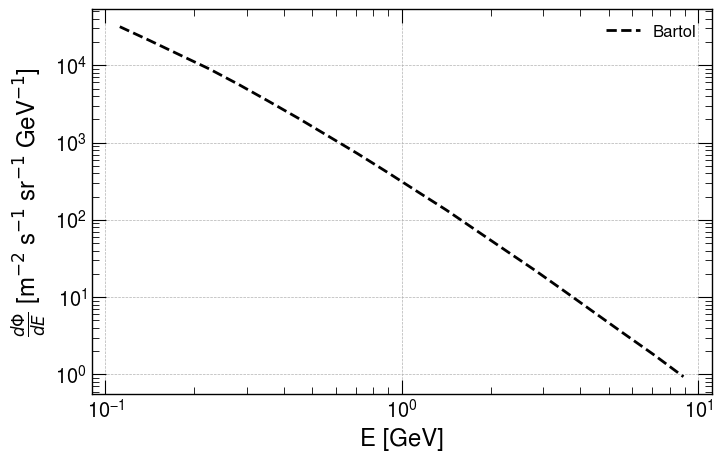

In [134]:
plt.figure(figsize=(8, 5))
plt.plot(df_results[:,0],df_results[:,1], ls = '--',label = 'Bartol')
#plt.plot((x_edges[:-1] + x_edges[1:]) / 2, proj_x, color='blue', label="Honda")


plt.xlabel(r'E [GeV]')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel(r"$\frac{d\Phi}{dE}$ [m$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV$^{-1}$]")
plt.grid()
plt.show()